# XGBoost on stock price

### Train, validate time series split

Fold 1: RMSE = 7.4579
Fold 2: RMSE = 5.0021
Fold 3: RMSE = 14.6866
Fold 4: RMSE = 5.9795
Fold 5: RMSE = 6.8515

Average RMSE: 7.9955
Best Fold RMSE: 5.0021
Worst Fold RMSE: 14.6866


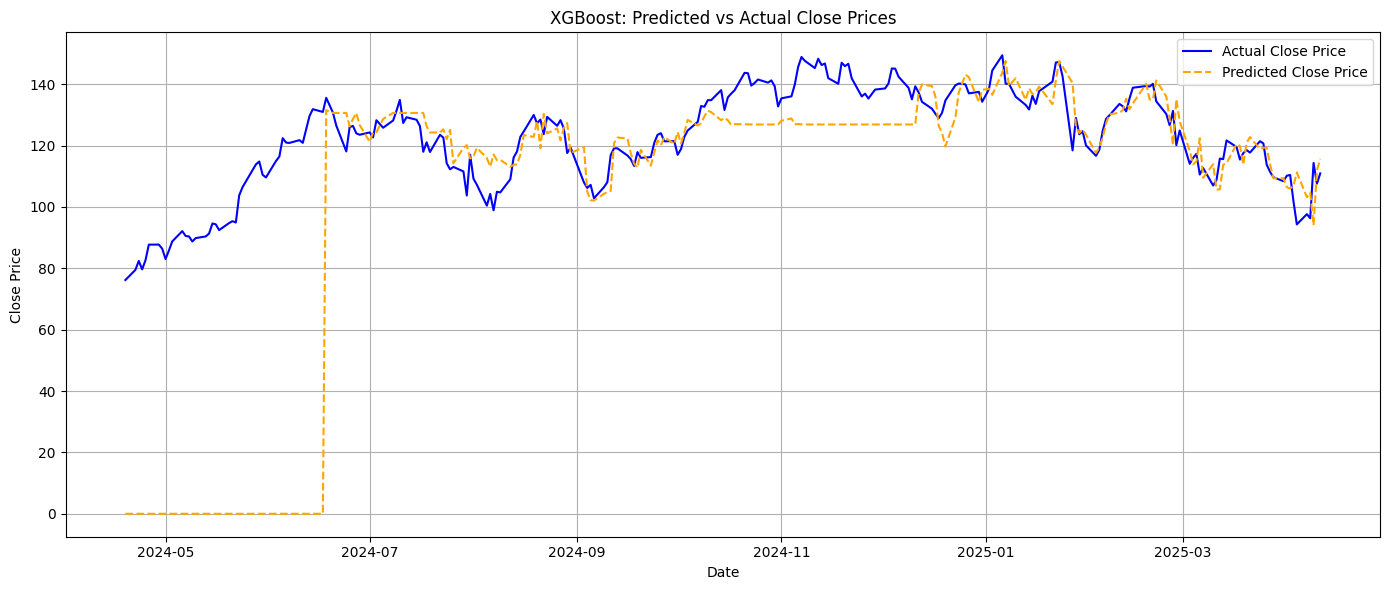

In [5]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

# Load and prepare data
df = pd.read_csv("NVDA_1d_1y.csv")
df.columns = df.columns.str.strip()
df['Close'] = df['Close'].ffill()

# Optional: Convert 'Date' column to datetime and use it as index if available
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=False)
    df.set_index('Date', inplace=True)

# Step 1: Create lag features
def create_lag_features(df, target_col='Close', lags=[1, 2, 3, 4, 5]):
    for lag in lags:
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    df = df.dropna()  # Drop rows with NaN due to lagging
    return df

# Apply lag feature generation
lags = [1, 2, 3, 4, 5]
df_lagged = create_lag_features(df.copy(), lags=lags)

# Reorder columns: lag_5 to lag_1, then Close
ordered_cols = [f'lag_{lag}' for lag in reversed(lags)] + ['Close']
df_lagged = df_lagged[ordered_cols]

# Save lagged dataset to CSV
df_lagged.to_csv("lagged_nvda_stock_data_train_val.csv", index=True)

# Step 2: Split features and target
X = df_lagged[[f'lag_{lag}' for lag in reversed(lags)]].values  # lag_5 to lag_1
y = df_lagged['Close'].values

# Step 3: TimeSeriesSplit Cross Validation
tscv = TimeSeriesSplit(n_splits=5)
model = XGBRegressor(n_estimators=10000, learning_rate=0.1, max_depth=15)

rmse_scores = []
predictions = np.zeros(len(y))

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions[test_idx] = y_pred

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)
    print(f"Fold {fold + 1}: RMSE = {rmse:.4f}")

# Step 4: Print RMSE Summary
print(f"\nAverage RMSE: {np.mean(rmse_scores):.4f}")
print(f"Best Fold RMSE: {min(rmse_scores):.4f}")
print(f"Worst Fold RMSE: {max(rmse_scores):.4f}")

# Step 5: Plot predictions vs actual
plt.figure(figsize=(14, 6))
if isinstance(df_lagged.index, pd.DatetimeIndex):
    x_axis = df_lagged.index
else:
    x_axis = range(len(y))

plt.plot(x_axis, y, label="Actual Close Price", color="blue")
plt.plot(x_axis, predictions, label="Predicted Close Price", linestyle='--', color="orange")
plt.title("XGBoost: Predicted vs Actual Close Prices")
plt.xlabel("Date" if isinstance(x_axis, pd.DatetimeIndex) else "Time Index")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Feature Importance

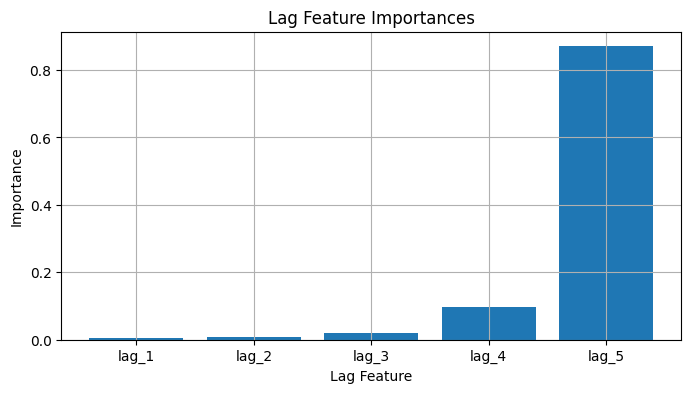

In [6]:
import matplotlib.pyplot as plt

model.fit(X, y)
plt.figure(figsize=(8, 4))
plt.bar([f'lag_{lag}' for lag in lags], model.feature_importances_)
plt.title("Lag Feature Importances")
plt.xlabel("Lag Feature")
plt.ylabel("Importance")
plt.grid(True)
plt.show()

### Recursive forecast

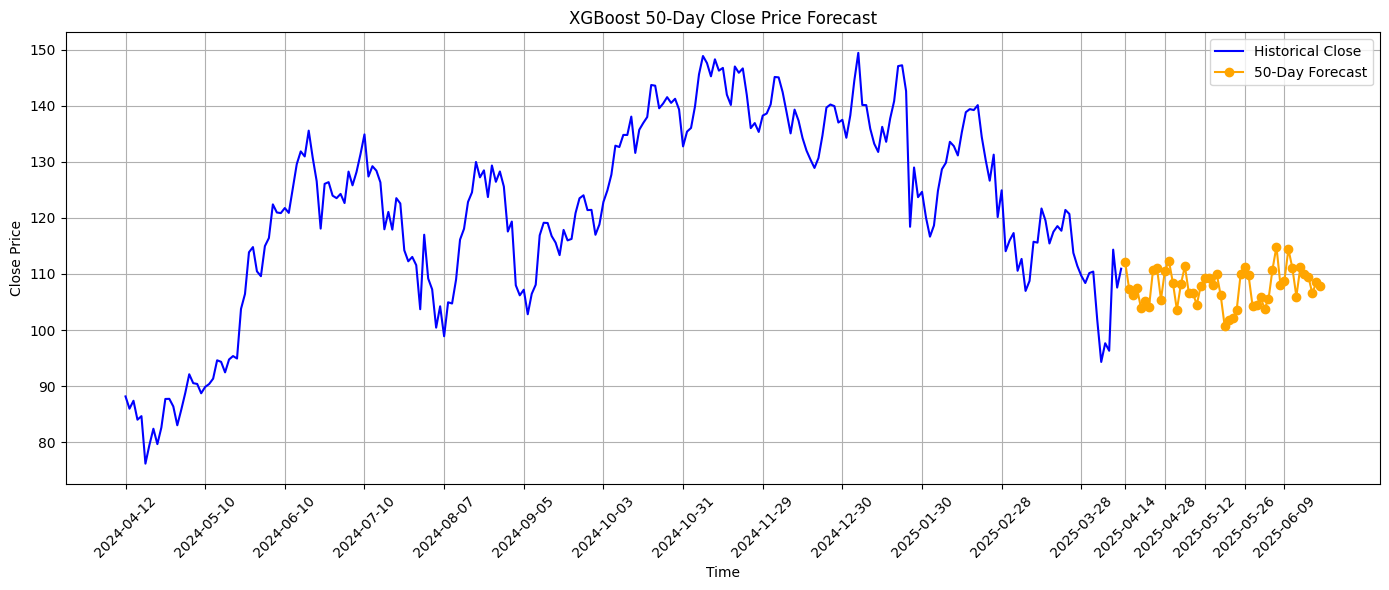

In [7]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# Load and prepare data
df = pd.read_csv("NVDA_1d_1y.csv")
df.columns = df.columns.str.strip()

# Handle dates correctly if present
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=False)
    df.set_index('Date', inplace=True)

df['Close'] = df['Close'].ffill()

# Step 1: Create lag features
def create_lag_features(df, target_col='Close', lags=[1, 2, 3, 4, 5]):
    for lag in lags:
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    df = df.dropna()
    return df

# Step 2: Define lags and prepare features
lags = [1, 2, 3, 4, 5]
df_lagged = create_lag_features(df.copy(), lags=lags)

# Reorder columns: lag_5, lag_4, ..., lag_1, Close
ordered_cols = [f'lag_{lag}' for lag in reversed(lags)] + ['Close']
df_lagged = df_lagged[ordered_cols]

# Save lagged dataset to CSV
df_lagged.to_csv("lagged_nvda_stock_data_recusive.csv")

# Prepare features and target
X = df_lagged[[f'lag_{lag}' for lag in reversed(lags)]].values
y = df_lagged['Close'].values

# Step 3: Train on all data
model = XGBRegressor(n_estimators=1000, learning_rate=0.1, max_depth=9)
model.fit(X, y)

# Step 4: Forecast next 50 days
last_known = df['Close'].values[-max(lags):].tolist()
future_predictions = []

for i in range(50):
    input_features = [last_known[-lag] for lag in reversed(lags)]
    input_array = np.array(input_features).reshape(1, -1)
    next_pred = model.predict(input_array)[0]
    future_predictions.append(next_pred)
    last_known.append(next_pred)

# Step 5: Plot actual data and forecast
plt.figure(figsize=(14, 6))
plt.plot(df['Close'].values, label="Historical Close", color="blue")

# Plot future forecast
future_x = range(len(df), len(df) + 50)
plt.plot(future_x, future_predictions, marker='o', label="50-Day Forecast", color="orange")

# Optional: Add future dates on x-axis if datetime index is available
if isinstance(df.index, pd.DatetimeIndex):
    last_date = df.index[-1]
    forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=50, freq='B')  # Business days
    plt.xticks(
        ticks=list(range(0, len(df), 20)) + list(future_x[::10]),
        labels=list(df.index.strftime('%Y-%m-%d')[::20]) + list(forecast_dates.strftime('%Y-%m-%d')[::10]),
        rotation=45
    )

plt.title("XGBoost 50-Day Close Price Forecast")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 6: Save forecast to CSV
forecast_df = pd.DataFrame({
    'Day': range(1, 51),
    'Forecast_Close': future_predictions
})

# Optional: Add actual forecast dates if index was datetime
if isinstance(df.index, pd.DatetimeIndex):
    forecast_df['Forecast_Date'] = forecast_dates

forecast_df.to_csv("nvda_50_day_forecast_recursive.csv", index=False)

### Direct multi-output forecast

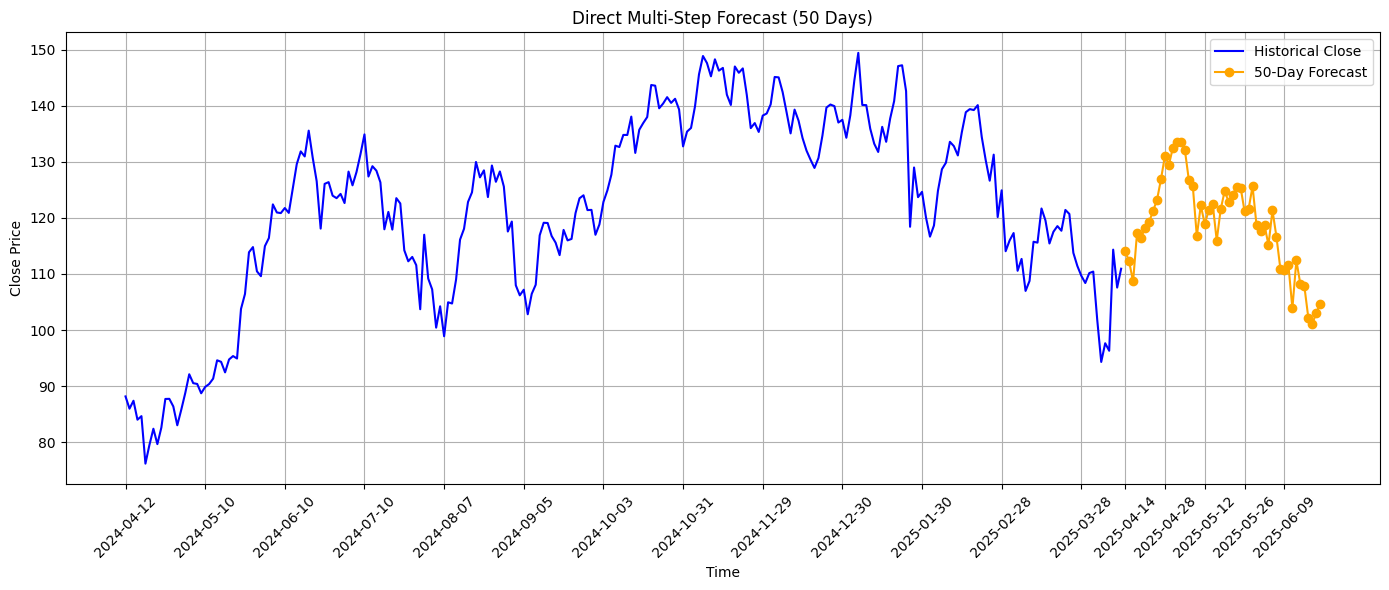

In [8]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
import matplotlib.pyplot as plt

# Load and prepare data
df = pd.read_csv("NVDA_1d_1y.csv")
df.columns = df.columns.str.strip()

# Parse and set datetime index if available
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=False)
    df.set_index('Date', inplace=True)

df['Close'] = df['Close'].ffill()

# Step 1: Create lag and target features
def create_multi_step_dataset(df, target_col='Close', lags=5, steps=50):
    data = []
    target = []
    close_vals = df[target_col].values
    for i in range(lags, len(close_vals) - steps):
        data.append(close_vals[i - lags:i])  # Keep order: lag_5 (oldest) to lag_1 (newest)
        target.append(close_vals[i:i + steps])
    return np.array(data), np.array(target)

# Step 2: Prepare dataset
X, y = create_multi_step_dataset(df, lags=5, steps=50)

# Update lagged column names to reflect lag_5 (oldest) to lag_1 (most recent)
lagged_columns = [f'lag_{i}' for i in range(5, 0, -1)]

# Prepare the lagged dataframe with date as the first column
lagged_df = pd.DataFrame(X, columns=lagged_columns, index=df.index[5:len(df) - 50])

# Add the 'Close' column from the original DataFrame
lagged_df['Close'] = df['Close'].values[5:len(df) - 50]

# Add the 'Date' column to the DataFrame
lagged_df['Date'] = df.index[5:len(df) - 50]

# Reorder the columns: date, lag_5, lag_4, lag_3, lag_2, lag_1, close
lagged_df = lagged_df[['Date'] + lagged_columns + ['Close']]

# Save the lagged dataset to CSV (Only save once)
lagged_df.to_csv("lagged_nvda_stock_data_direct.csv", index=False)

# Step 3: Train model
model = MultiOutputRegressor(XGBRegressor(n_estimators=1000, learning_rate=0.1, max_depth=9))
model.fit(X, y)

# Step 4: Predict next 50 days
last_input = df['Close'].values[-5:]
X_future = last_input.reshape(1, -1)
y_pred = model.predict(X_future).flatten()

# Step 5: Plot
plt.figure(figsize=(14, 6))
plt.plot(df['Close'].values, label="Historical Close", color="blue")
future_x = range(len(df), len(df) + 50)
plt.plot(future_x, y_pred, marker='o', label="50-Day Forecast", color="orange")

# Plot dates if available
if isinstance(df.index, pd.DatetimeIndex):
    last_date = df.index[-1]
    forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=50, freq='B')
    plt.xticks(ticks=list(range(0, len(df), 20)) + list(future_x[::10]),
               labels=list(df.index.strftime('%Y-%m-%d')[::20]) + list(forecast_dates.strftime('%Y-%m-%d')[::10]),
               rotation=45)

plt.title("Direct Multi-Step Forecast (50 Days)")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 6: Save forecast
forecast_df = pd.DataFrame({
    'Day': range(1, 51),
    'Forecast_Close': y_pred
})
if isinstance(df.index, pd.DatetimeIndex):
    forecast_df['Forecast_Date'] = forecast_dates

forecast_df.to_csv("nvda_50_day_forecast_direct.csv", index=False)